In [ ]:
import numpy as np
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras

# om output te tonen
import matplotlib.pyplot as plt
import os
import time


# Dataset binnenhalen

Om Alexnet te trainen gebruiken we een kant en klare database van images: **keras.datasets** refereert naar ingebouwde datasets, die kunnen we laden.

We gebruiken CIFAR database, zie de webpagina voor meer info: https://www.cs.toronto.edu/%7Ekriz/cifar.htmlEen .

Deze dataset bevat 50.000 32x32 (kleuren) afbeeldingen om te trainen en 10.000 on te testen. Data heeft 10 categorien.

Call naar db retourneert een Tuple van NumPy arrays: (x_train, y_train), (x_test, y_test).


In [ ]:
#x_train(en x_test): een NumPy array met pixel data.
# pixel waardes zijn grijswaardes van elk kanaal (R, G, B), dus 3 in totaal
# de afbeelding is een matrix van 32 bij 32 pixels.
# de vorm van de numpyarray is dus (aantal, 32, 32, 3)
# aantal is 50000 voor de training set en 10000 voor de test set

#y_train (en y_test): een numPy array met labels data, labels zijn in de gerepresenteerd als een integer en lopen van 0-9
# de vorm van de array is dus (aantal, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Data is gelabeld op 10 categroieen (zie ook [Keras documentatie](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data))

In [ ]:

# we gebruiken tf.data.Dataset als een manier om met (veel) data te kunnen werken.
# aan tf.data.Dataset zit ook een API aan vast die pipeline opbouwen makkelijker maakt.
# het is heel makkelijk om een tensor in te laden (uit bijvoorbeeld een lijst/array)

dataset_train=tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset_test=tf.data.Dataset.from_tensor_slices((x_test,y_test))

De images zijn nu als het goed is geladen. We tonen nu elkele images op het scherm.


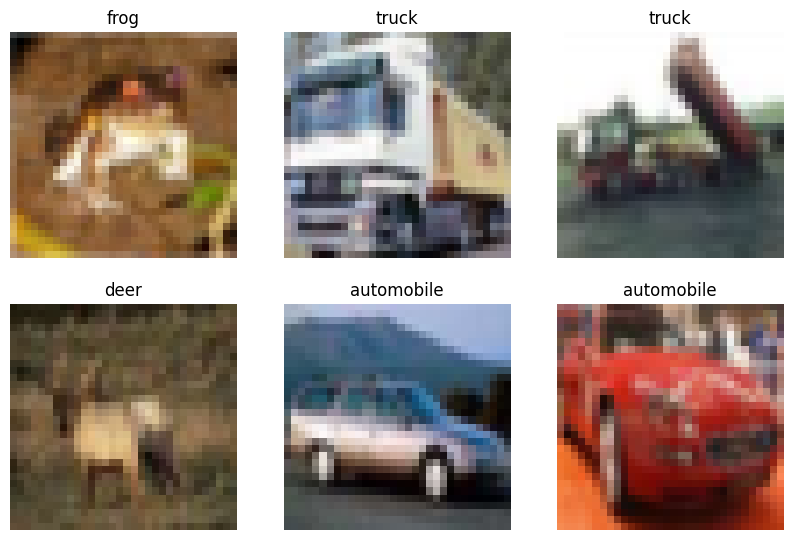

In [ ]:

# we maken een lijst van strings die overheenkomen met de labels om deze te kunnen printen (ipv getallen)
class_names= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
i = 0

#show 6 images from dataset
for image, label in dataset_train.take(6):
    ax = plt.subplot(3, 3, i+ 1)
    plt.imshow(image)
    plt.title(class_names[label[0]])
    i = i+1
    plt.axis("off")



# Preprocessing stap

Elke image in de dataset moet op dezelfde manier worden voorbereid om vergeleken kunnen te worden.

Zo willen we de waardes niet niet als integers van 0 tot 255 hebben, maar als float en 0 als mean. Om dit te bereiken heeft keras **per_image_standardization** functie: *Linearly scales each image in image to have mean 0 and variance 1*.

Een andere belangerijke voorwaarde is dat alle images even groot zijn qua afmetingen. Daarom doen we de **resize** functie met bijv 64 bij 64


In [1]:
#preprocess an image - bring to standart format

def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))

    return image,label
















Data Pipeline

1. Preprocessing the data within the dataset

2. Shuffle the dataset
3. Batch data within the dataset



In [ ]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )




Model Implementation¶

Within this section, we will implement the AlexNet CNN architecture from scratch. Through the utilization of Keras Sequential API, we can implement consecutive neural network layers within our models that are stacked against each other.

Here are the types of layers the AlexNet CNN architecture is composed of, along with a brief description:
Convolutional layer:

A convolution is a mathematical term that describes a dot product multiplication between two sets of elements. Within deep learning the convolution operation acts on the filters/kernels and image data array within the convolutional layer. Therefore a convolutional layer is simply a layer the houses the convolution operation that occurs between the filters and the images passed through a convolutional neural network.
Batch Normalisation layer:

Batch Normalization is a technique that mitigates the effect of unstable gradients within a neural network through the introduction of an additional layer that performs operations on the inputs from the previous layer. The operations standardize and normalize the input values, after that the input values are transformed through scaling and shifting operations.
MaxPooling layer:

Max pooling is a variant of sub-sampling where the maximum pixel value of pixels that fall within the receptive field of a unit within a sub-sampling layer is taken as the output. The max-pooling operation below has a window of 2x2 and slides across the input data, outputting an average of the pixels within the receptive field of the kernel.
Flatten layer:

Takes an input shape and flattens the input image data into a one-dimensional array.
Dense Layer:

A dense layer has an embedded number of arbitrary units/neurons within. Each neuron is a perceptron.

The code snippet represents the Keras implementation of the AlexNet CNN architecture.


In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')


])


Training and Results¶

To train the network, we have to compile it.

The compilation processes involve specifying the following items:
Loss function:

A method that quantifies ‘how well’ a machine learning model performs. The quantification is an output(cost) based on a set of inputs, which are referred to as parameter values. The parameter values are used to estimate a prediction, and the ‘loss’ is the difference between the predictions and the actual values.
Optimization Algorithm:

An optimizer within a neural network is an algorithmic implementation that facilitates the process of gradient descent within a neural network by minimizing the loss values provided via the loss function. To reduce the loss, it is paramount the values of the weights within the network are selected appropriately.
Learning Rate:

An integral component of a neural network implementation detail as it’s a factor value that determines the level of updates that are made to the values of the weights of the network. Learning rate is a type of hyperparameter.

We can also provide a summary of the network to have more insight into the layer composition of the network by running the model.summary() function.


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       46592     
                                                                 
 batch_normalization (Batch  (None, 14, 14, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 128)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         819456    
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                        



At this point, we are ready to train the network.

Training the custom AlexNet network is very simple with the Keras module enabled through TensorFlow. We simply have to call the fit() method and pass relevant arguments.

Epoch: This is a numeric value that indicates the number of time a network has been exposed to all the data points within a training dataset.


In [ ]:
history=model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/50
1562/1562 [==============================] - 512s 323ms/step - loss: 2.1312 - accuracy: 0.2525 - val_loss: 1.6086 - val_accuracy: 0.4248
Epoch 2/50
1562/1562 [==============================] - 506s 320ms/step - loss: 1.7087 - accuracy: 0.3836 - val_loss: 1.4354 - val_accuracy: 0.4823
Epoch 3/50
1562/1562 [==============================] - 507s 322ms/step - loss: 1.5370 - accuracy: 0.4479 - val_loss: 1.3296 - val_accuracy: 0.5213
Epoch 4/50
1562/1562 [==============================] - 512s 324ms/step - loss: 1.4170 - accuracy: 0.4921 - val_loss: 1.2607 - val_accuracy: 0.5504
Epoch 5/50
1562/1562 [==============================] - 516s 326ms/step - loss: 1.3119 - accuracy: 0.5340 - val_loss: 1.1921 - val_accuracy: 0.5756
Epoch 6/50
1562/1562 [==============================] - 511s 324ms/step - loss: 1.2285 - accuracy: 0.5643 - val_loss: 1.1273 - val_accuracy: 0.6018
Epoch 7/50
1562/1562 [==============================] - 511s 324ms/step - loss: 1.1543 - accuracy: 0.5924 - val_

KeyboardInterrupt: 

In [ ]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

ow we will visualize the training over the different epochs .

NameError: name 'history' is not defined

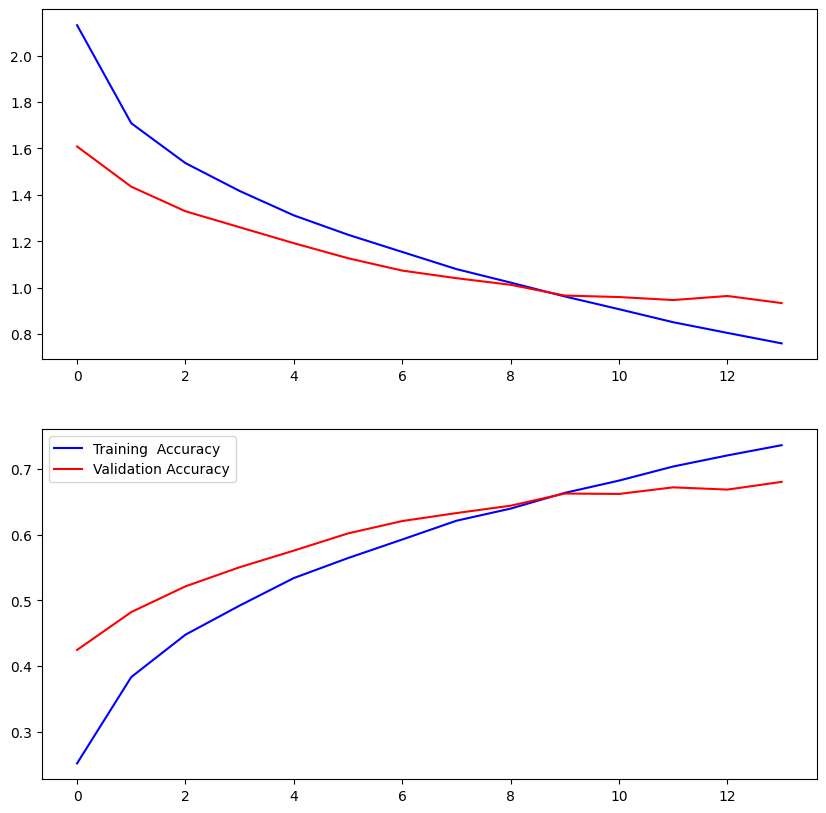

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10))

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

print('Accuracy Score = ',np.max(history.history['val_accuracy']))